<a href="https://colab.research.google.com/github/Lreinoso15/serie_ACARA_patentamientos_2014-2022/blob/main/TP_II_AST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/diegofloresval/ast-tpii/blob/main/coffee_sales_forecasting_template.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>


In [ ]:
# ==============================
# Instalación de librerías
# ==============================
!pip install --quiet pandas numpy matplotlib statsmodels prophet holidays scikit-learn tensorflow

# ==============================
# Importación de librerías (actualizado para quantities y models)
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet
from prophet import Prophet

# Holidays
import holidays

# ML/DL
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras import layers

# Utilidades
from itertools import product
from scipy.stats import skew, kurtosis
import seaborn as sns


In [ ]:
# Clonar el repositorio de GitHub con el material del trabajo práctico
!git clone https://github.com/diegofloresval/ast-tpii.git

# Verificar archivos disponibles
!ls ast-tpii


Cloning into 'ast-tpii'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 194.90 KiB | 7.79 MiB/s, done.
Coffe_sales.xlsx


## 1. Carga y exploración de datos

In [ ]:
# Carga Excel
df = pd.read_excel("ast-tpii/Coffe_sales.xlsx", engine='openpyxl')

print("Columnas disponibles:", df.columns.tolist(), "\n")

# Normalizar nombres esperados según tu archivo
assert {"date","money"}.issubset(df.columns), f"Esperaba columnas 'date' y 'money'. Detectadas: {df.columns.tolist()}"

# Tipos y orden temporal
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# Cambiado a cantidades: asumir 1 unidad por transacción (no hay columna quantity explícita)
df['quantity'] = 1

# Info general
print("=== Primeras 5 filas ===")
display(df.head())

print("\n=== Información de columnas ===")
print(df.info())

print("\n=== Valores nulos por columna ===")
print(df.isnull().sum())

print("\n=== Filas duplicadas (todas las columnas) ===")
print(df.duplicated().sum())

# Rango y frecuencia
fecha_min, fecha_max = df["date"].min(), df["date"].max()
n_obs = len(df)
freq_inferida = pd.infer_freq(df["date"])

print("\n➤ Rango temporal:", fecha_min.date(), "→", fecha_max.date())
print("➤ Observaciones:", n_obs)
print("➤ Frecuencia inferida:", freq_inferida, "(None si no es perfectamente regular)")


Columnas disponibles: ['date', 'datetime', 'hour_of_day', 'cash_type', 'card', 'money', 'coffee_name', 'Time_of_Day', 'Weekday', 'Month_name', 'Weekdaysort', 'Monthsort'] 

=== Primeras 5 filas ===


,date,datetime,hour_of_day,cash_type,card,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,quantity
0,2024-03-01,2024-03-01 10:15:50.520,10,card,ANON-0000-0000-0001,38.7,Latte,Morning,Fri,Mar,5,3,1
1,2024-03-01,2024-03-01 19:23:15.887,19,card,ANON-0000-0000-0008,33.8,Americano with Milk,Night,Fri,Mar,5,3,1
2,2024-03-01,2024-03-01 19:22:01.762,19,card,ANON-0000-0000-0008,38.7,Cocoa,Night,Fri,Mar,5,3,1
3,2024-03-01,2024-03-01 18:39:03.580,18,card,ANON-0000-0000-0007,33.8,Americano with Milk,Night,Fri,Mar,5,3,1
4,2024-03-01,2024-03-01 16:19:02.756,16,card,ANON-0000-0000-0006,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,1



=== Información de columnas ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3636 non-null   datetime64[ns]
 1   datetime     3636 non-null   datetime64[ns]
 2   hour_of_day  3636 non-null   int64         
 3   cash_type    3636 non-null   object        
 4   card         3547 non-null   object        
 5   money        3636 non-null   float64       
 6   coffee_name  3636 non-null   object        
 7   Time_of_Day  3636 non-null   object        
 8   Weekday      3636 non-null   object        
 9   Month_name   3636 non-null   object        
 10  Weekdaysort  3636 non-null   int64         
 11  Monthsort    3636 non-null   int64         
 12  quantity     3636 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(6)
memory usage: 369.4+ KB
None

=== Valores nulos por columna ===
da


=== Cantidades por tipo de café ===
coffee_name
Americano with Milk    824
Latte                  782
Americano              578
Cappuccino             501
Cortado                292
Hot Chocolate          282
Cocoa                  243
Espresso               134
Name: quantity, dtype: int64


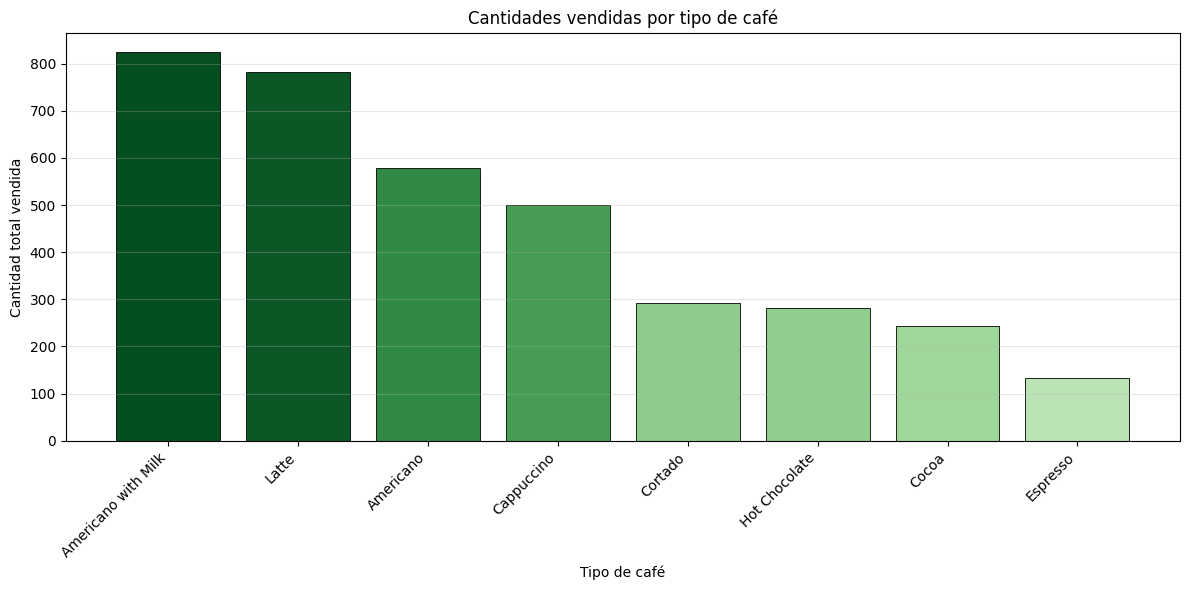


=== Coeficiente de variación (CV) por tipo de café (menor = más predecible) ===
coffee_name
Latte                  0.850127
Americano with Milk    0.875347
Cappuccino             0.994765
Americano              1.198939
Cortado                1.339042
Hot Chocolate          1.498203
Cocoa                  1.667896
Espresso               1.849983
dtype: float64

➤ Tipo de café más predecible para modelado: Latte (CV: 0.850)


/tmp/ipython-input-2729135714.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Time_of_Day', as_index=False)['quantity'].sum()


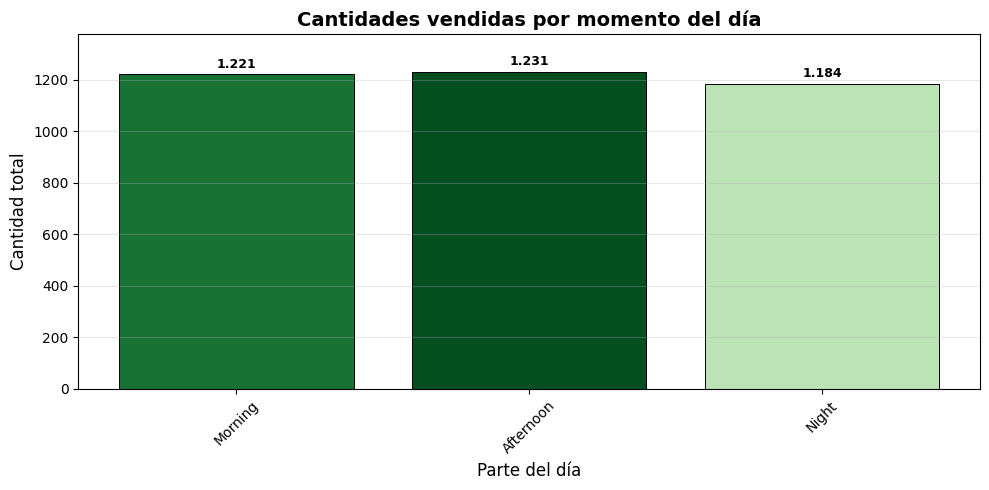

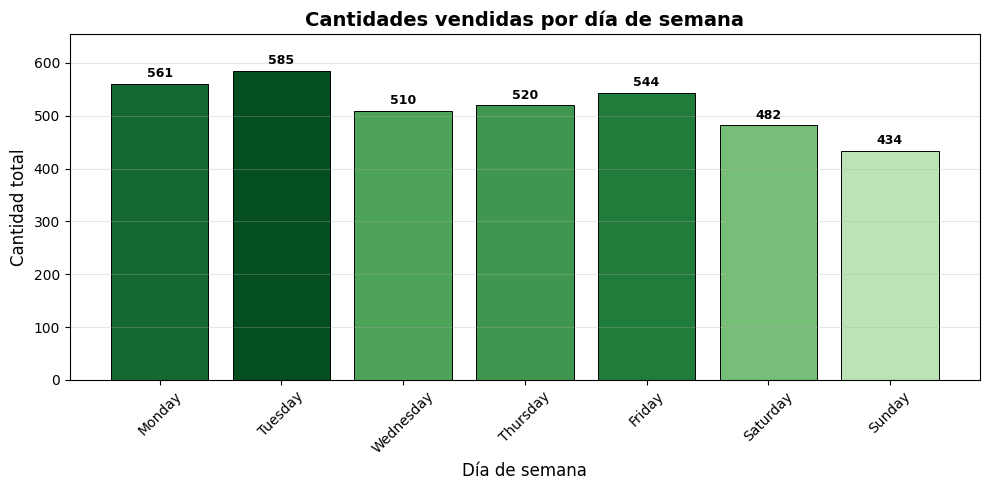

/tmp/ipython-input-2729135714.py:158: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_year = df.groupby(['Month_name','year'], as_index=False)['quantity'].sum()


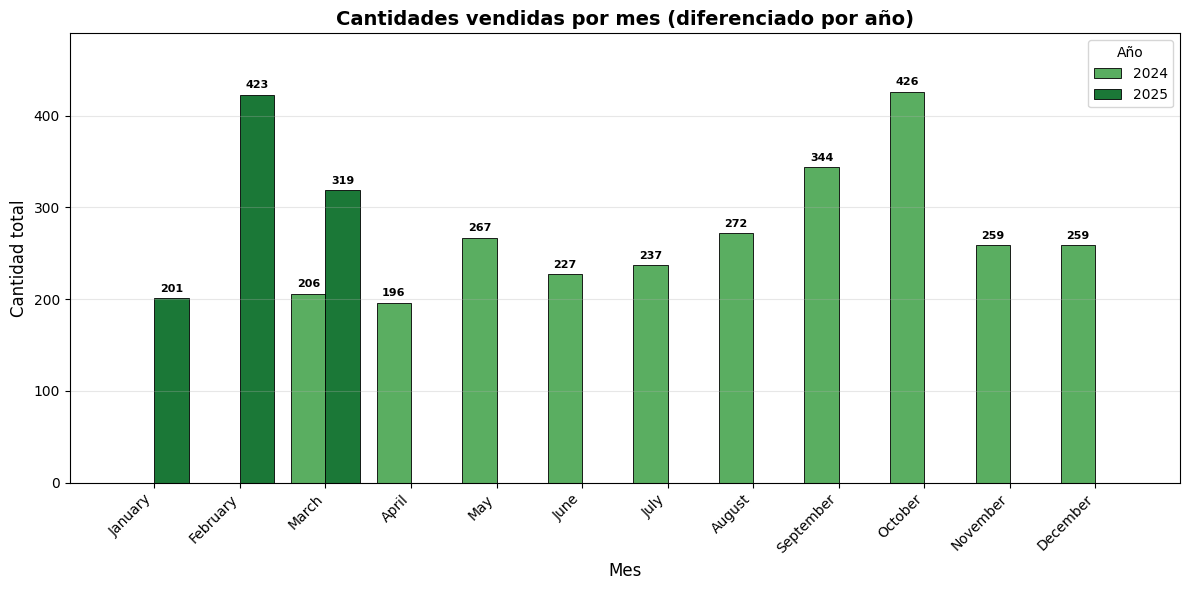

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# =========================================================
# 0) Setup y utilidades
# =========================================================
df = df.copy()

# Tipos
if not np.issubdtype(df['date'].dtype, np.datetime64):
    df['date'] = pd.to_datetime(df['date'])
df['coffee_name'] = df['coffee_name'].astype(str).str.strip()
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce').fillna(0)

# Derivados
df['year'] = df['date'].dt.year
df['Month_name'] = df['date'].dt.month_name()
df['Weekday'] = df['date'].dt.day_name()
if 'Time_of_Day' not in df.columns:
    hour = df['date'].dt.hour
    df['Time_of_Day'] = pd.cut(
        hour, bins=[-1, 11, 17, 24],
        labels=['Morning','Afternoon','Night']
    )

# Órdenes
ORDER_TIME    = ['Morning','Afternoon','Night']
ORDER_WEEKDAY = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ORDER_MONTH   = ['January','February','March','April','May','June','July',
                 'August','September','October','November','December']

# =========================================================
# 1) Paleta VERDE y mapeo correcto (alto -> oscuro)
# =========================================================
# Paleta de verdes en orden claro -> oscuro
GREENS_HEX = ['#d9f0d3', '#a6dba0', '#5aae61', '#1b7837', '#00441b']

def _hex_to_rgb01(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255.0 for i in (0, 2, 4))

def make_cmap_from_hex(hex_list):
    # hex_list YA está claro -> oscuro
    rgbs = [_hex_to_rgb01(h) for h in hex_list]
    return LinearSegmentedColormap.from_list('greens_custom', rgbs, N=256)

CMAP = make_cmap_from_hex(GREENS_HEX)

def colors_by_value(values, cmap=CMAP):
    """Mayor valor -> color más oscuro."""
    v = np.asarray(values, dtype=float)
    if v.size == 0:
        return []
    if np.all(v == v[0]):              # todos iguales
        t = np.full_like(v, 0.7, dtype=float)
    else:
        # normalizamos: bajo=0 (claro), alto=1 (oscuro)
        t = (v - v.min()) / (v.max() - v.min())
        # evitamos extremos ultra pálidos u oscuros
        t = 0.15 + 0.80 * t            # 0.15..0.95
    return cmap(t)

def bar_with_labels(x_labels, values, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10,5))
    cols = colors_by_value(values)      # aquí se respeta alto->oscuro
    bars = ax.bar(x_labels, values, color=cols, edgecolor='black', linewidth=0.7)
    ymax = max(values)*1.12 if len(values) else 1.0
    ax.set_ylim(0, ymax)
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x()+b.get_width()/2, h + ymax*0.01,
                f'{int(round(h)):,}'.replace(',', '.'),
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

# =========================================================
# 2) Cantidades por tipo de café (alto -> oscuro)
# =========================================================
print("\n=== Cantidades por tipo de café ===")
coffee_counts = df.groupby('coffee_name', as_index=True)['quantity'].sum().sort_values(ascending=False)
print(coffee_counts)

plt.figure(figsize=(12,6))
cols = colors_by_value(coffee_counts.values)  # alto -> oscuro
plt.bar(coffee_counts.index, coffee_counts.values,
        color=cols, edgecolor='black', linewidth=0.6)
plt.title('Cantidades vendidas por tipo de café')
plt.xlabel('Tipo de café'); plt.ylabel('Cantidad total vendida')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

# =========================================================
# 3) Variabilidad por tipo (CV) y serie diaria del tipo más predecible
# =========================================================
daily_by_type = (
    df.groupby(['date','coffee_name'], as_index=False)['quantity']
      .sum()
      .pivot(index='date', columns='coffee_name', values='quantity')
      .fillna(0)
)

means = daily_by_type.mean()
stds  = daily_by_type.std(ddof=1)
cv_by_type = (stds / means.replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).dropna().sort_values()

print("\n=== Coeficiente de variación (CV) por tipo de café (menor = más predecible) ===")
print(cv_by_type)

most_predictable_type = cv_by_type.index[0]
print(f"\n➤ Tipo de café más predecible para modelado: {most_predictable_type} (CV: {cv_by_type.iloc[0]:.3f})")

daily_selected = (
    daily_by_type[most_predictable_type]
    .asfreq('D')
    .fillna(0)
    .to_frame(name='quantity')
)

# =========================================================
# 4) Gráficos agregados
#    a) Parte del día  (alto -> oscuro)
#    b) Día de semana  (alto -> oscuro)
#    c) Mes × Año      (SOLO dos colores, uno por año)
# =========================================================

# a) Parte del día
qty_time = (
    df.groupby('Time_of_Day', as_index=False)['quantity'].sum()
      .set_index('Time_of_Day').reindex(ORDER_TIME).fillna(0).reset_index()
)
bar_with_labels(
    x_labels=qty_time['Time_of_Day'].astype(str).tolist(),
    values=qty_time['quantity'].to_numpy(),
    title='Cantidades vendidas por momento del día',
    xlabel='Parte del día', ylabel='Cantidad total'
)

# b) Día de semana
qty_wd = (
    df.groupby('Weekday', as_index=False)['quantity'].sum()
      .set_index('Weekday').reindex(ORDER_WEEKDAY).fillna(0).reset_index()
)
bar_with_labels(
    x_labels=qty_wd['Weekday'].astype(str).tolist(),
    values=qty_wd['quantity'].to_numpy(),
    title='Cantidades vendidas por día de semana',
    xlabel='Día de semana', ylabel='Cantidad total'
)

# c) Mes × Año -> SOLO dos colores, sin degradar por valor
df['Month_name'] = pd.Categorical(df['Month_name'], categories=ORDER_MONTH, ordered=True)
month_year = df.groupby(['Month_name','year'], as_index=False)['quantity'].sum()
pvt = month_year.pivot(index='Month_name', columns='year', values='quantity').reindex(ORDER_MONTH).fillna(0)

fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(pvt.index))
years = list(pvt.columns)
n = len(years)
width = 0.8 / max(n, 1)

# Dos colores fijos (mismo tono para cada año)
# Elegí dos tonos contrastantes de la paleta verde:
year_palette = {}
base_two = ['#5aae61', '#1b7837']  # 2024 -> verde medio, 2025 -> verde oscuro
for i, yr in enumerate(years):
    year_palette[yr] = base_two[i % len(base_two)]

ymax = (pvt.values.max() if pvt.size else 1) * 1.15
for i, yr in enumerate(years):
    vals = pvt[yr].to_numpy()
    bars = ax.bar(x + i*width - (n-1)*width/2, vals, width=width,
                  label=str(yr), color=year_palette[yr],
                  edgecolor='black', linewidth=0.6)
    for b in bars:
        h = b.get_height()
        if h > 0:
            ax.text(b.get_x()+b.get_width()/2, h + ymax*0.01,
                    f'{int(round(h)):,}'.replace(',', '.'),
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_ylim(0, ymax)
ax.set_title('Cantidades vendidas por mes (diferenciado por año)', fontsize=14, fontweight='bold')
ax.set_xlabel('Mes', fontsize=12); ax.set_ylabel('Cantidad total', fontsize=12)
ax.set_xticks(x); ax.set_xticklabels(pvt.index, rotation=45, ha='right')
ax.grid(True, axis='y', alpha=0.3)
ax.legend(title='Año')
plt.tight_layout(); plt.show()

=== Estadísticos descriptivos (Latte) ===


,quantity
count,388.000000
mean,2.015464
std,1.750531
min,0.000000
1%,0.000000
5%,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
95%,5.000000


IQR: 2.000
Skewness: 1.101
Kurtosis: 1.457
➤ Outliers (Latte): 10


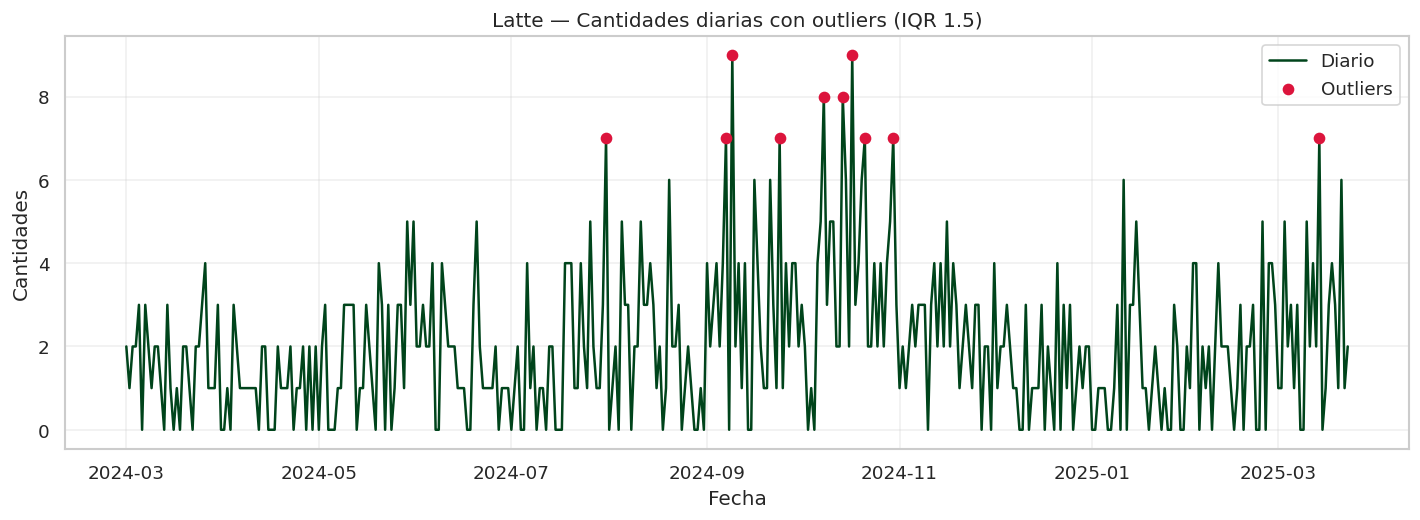

ADF Latte: -4.0387 | p-value: 0.0012


/tmp/ipython-input-905261174.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tmp, x="dow", y="quantity",


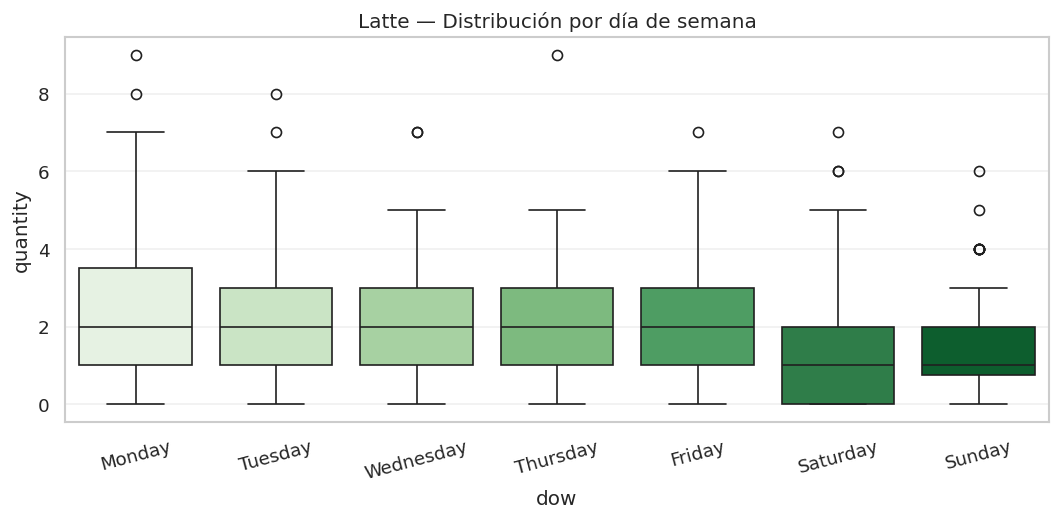

/tmp/ipython-input-905261174.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tmp, x="month_name", y="quantity", order=orden_meses, palette="Greens")


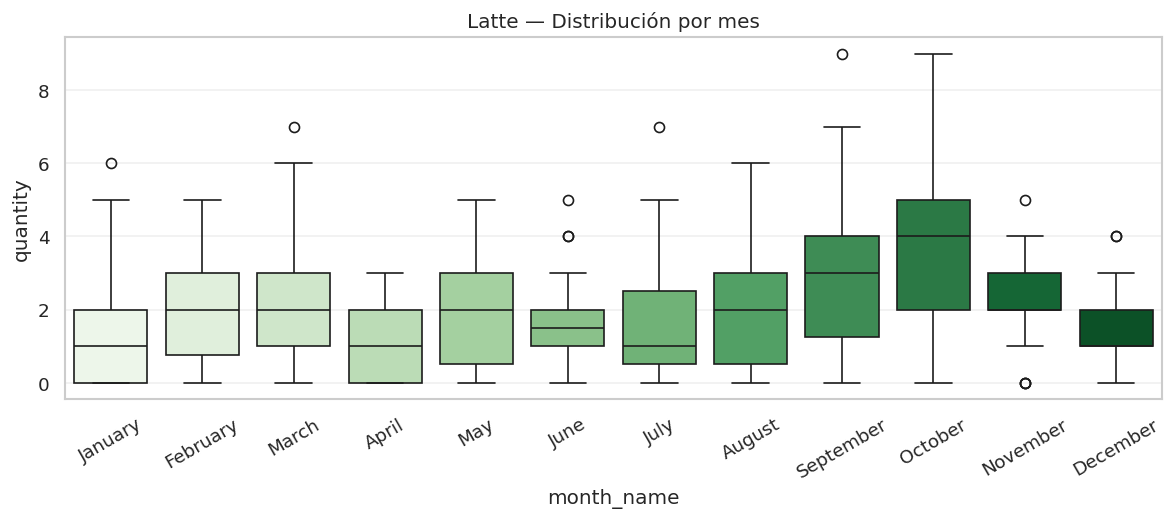

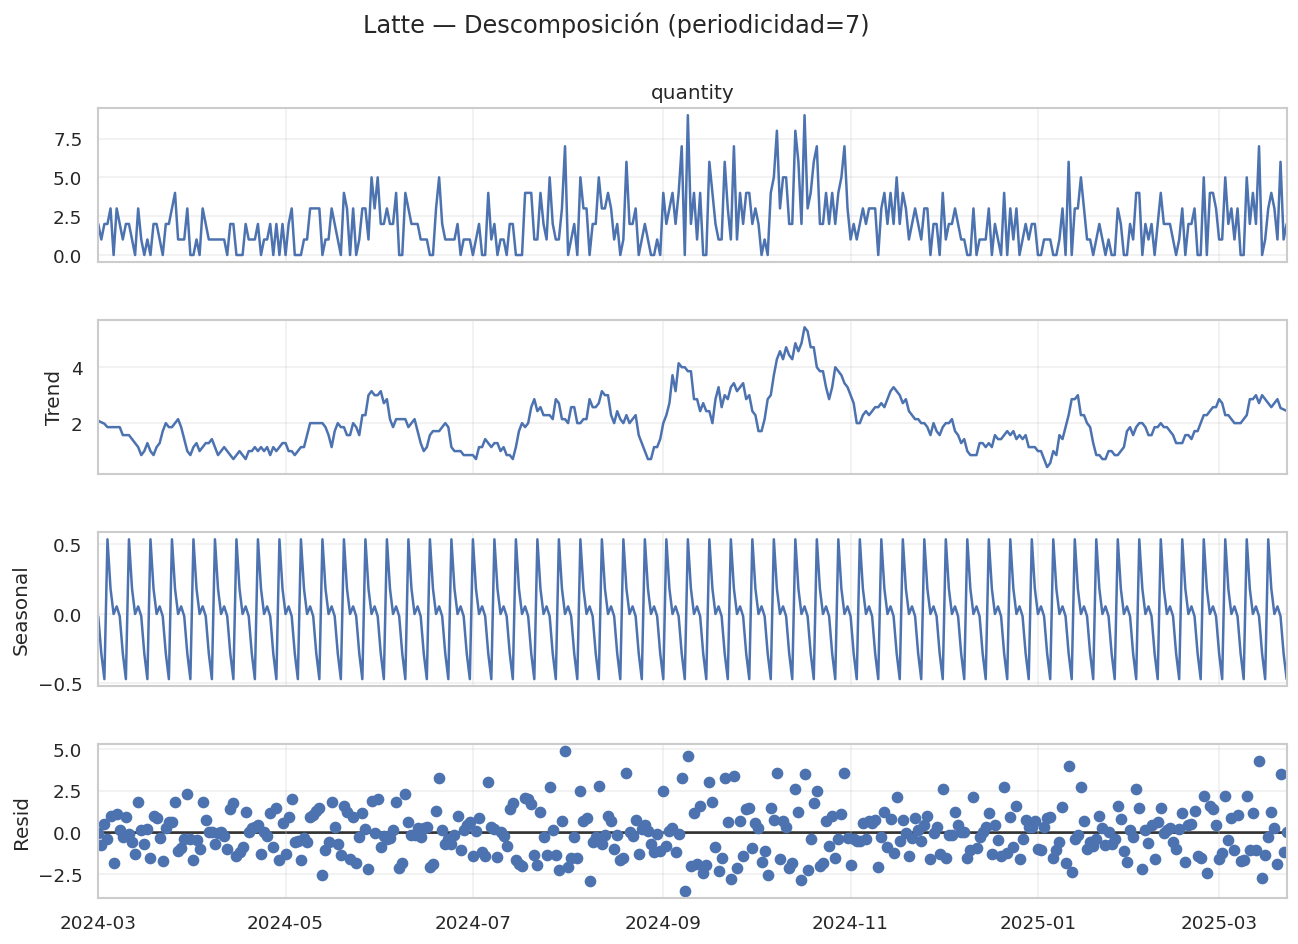

In [ ]:
# === ANÁLISIS: LATTE ===
serie = df_latte["quantity"]
desc = serie.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).to_frame("quantity")
iqr = desc.loc["75%","quantity"] - desc.loc["25%","quantity"]

print("=== Estadísticos descriptivos (Latte) ===")
display(desc)
print(f"IQR: {iqr:.3f}")
print(f"Skewness: {skew(serie, bias=False):.3f}")
print(f"Kurtosis: {kurtosis(serie, fisher=True, bias=False):.3f}")

q1, q3 = serie.quantile([0.25, 0.75])
low_thr, high_thr = q1 - 1.5*(q3-q1), q3 + 1.5*(q3-q1)
mask = (serie < low_thr) | (serie > high_thr)
print("➤ Outliers (Latte):", int(mask.sum()))
df_latte.loc[mask, ["date","quantity"]].to_csv("latte_outliers_iqr.csv", index=False)

plt.figure(figsize=(12,4.5))
plt.plot(df_latte["date"], df_latte["quantity"], color=GREENS[4], label="Diario")
plt.scatter(df_latte.loc[mask,"date"], df_latte.loc[mask,"quantity"], color="crimson", zorder=5, label="Outliers")
plt.title("Latte — Cantidades diarias con outliers (IQR 1.5)")
plt.xlabel("Fecha"); plt.ylabel("Cantidades"); plt.legend(); plt.tight_layout(); plt.show()

adf = adfuller(df_latte.set_index('date')['quantity'])
print(f"ADF Latte: {adf[0]:.4f} | p-value: {adf[1]:.4f}")

tmp = df_latte.assign(dow=df_latte['date'].dt.day_name(),
                      month_name=df_latte['date'].dt.month_name())
plt.figure(figsize=(9,4.5))
sns.boxplot(data=tmp, x="dow", y="quantity",
            order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
            palette="Greens")
plt.title("Latte — Distribución por día de semana"); plt.xticks(rotation=15); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4.5))
orden_meses = ["January","February","March","April","May","June","July","August","September","October","November","December"]
sns.boxplot(data=tmp, x="month_name", y="quantity", order=orden_meses, palette="Greens")
plt.title("Latte — Distribución por mes"); plt.xticks(rotation=30); plt.tight_layout(); plt.show()

if len(df_latte) >= 14:
    res = seasonal_decompose(df_latte.set_index("date")["quantity"], model="additive", period=7, extrapolate_trend="freq")
    fig = res.plot(); fig.set_size_inches(12,8); fig.suptitle("Latte — Descomposición (periodicidad=7)", y=1.02); plt.show()
else:
    print("⚠️ Datos insuficientes para descomposición (se requieren ≥ 14 observaciones).")


In [ ]:
# === Helpers de MODELADO: CV, SARIMAX, Auto-SARIMAX, Prophet, LightGBM ===
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import lightgbm as lgb

TS_FOLDS = 5

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def tscv_splits_index(n_samples, n_splits=TS_FOLDS):
    return TimeSeriesSplit(n_splits=n_splits).split(range(n_samples))

# --- SARIMAX baseline ---
def evaluate_sarimax_cv(y, order=(1,0,1), seasonal_order=(1,0,1,7),
                        enforce_stationarity=False, enforce_invertibility=False):
    y = y.astype(float)
    scores = []
    for tr_idx, te_idx in tscv_splits_index(len(y)):
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        res = SARIMAX(y_tr, order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=enforce_stationarity,
                      enforce_invertibility=enforce_invertibility).fit(disp=False)
        fc = res.forecast(steps=len(y_te))
        scores.append(rmse(y_te, fc))
    return scores, float(np.mean(scores))

# --- Auto-SARIMAX (grilla simple) ---
def auto_sarimax_endog(endog, s=7, criterion="aic",
                       p_range=range(0,4), d_range=range(0,2), q_range=range(0,4),
                       P_range=range(0,3), D_range=range(0,2), Q_range=range(0,3)):
    best_ic, best_cfg, best_res = np.inf, None, None
    for (p,d,q,P,D,Q) in product(p_range, d_range, q_range, P_range, D_range, Q_range):
        try:
            res = SARIMAX(endog, order=(p,d,q), seasonal_order=(P,D,Q,s),
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            ic = res.aic if criterion.lower()=='aic' else res.bic
            if np.isfinite(ic) and ic < best_ic:
                best_ic, best_cfg, best_res = ic, ((p,d,q),(P,D,Q,s)), res
        except Exception:
            continue
    return best_cfg, best_ic, best_res

def evaluate_auto_sarimax_cv(y, s=7, optimize_each_fold=False):
    y = y.astype(float)
    scores, best_cfg_global = [], None
    for k, (tr_idx, te_idx) in enumerate(tscv_splits_index(len(y))):
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        if optimize_each_fold or best_cfg_global is None:
            cfg, ic, res = auto_sarimax_endog(y_tr, s=s, criterion="aic")
            best_cfg = cfg
            if not optimize_each_fold:
                best_cfg_global = cfg
        else:
            (order, seasonal) = best_cfg_global
            res = SARIMAX(y_tr, order=order, seasonal_order=seasonal,
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        fc = res.forecast(steps=len(y_te))
        scores.append(rmse(y_te, fc))
    return scores, float(np.mean(scores)), best_cfg_global

# --- Prophet ---
def evaluate_prophet_cv(df_daily):
    dfp = df_daily.rename(columns={'date':'ds','quantity':'y'})[['ds','y','is_weekend','is_holiday']].copy()
    scores = []
    for tr_idx, te_idx in tscv_splits_index(len(dfp)):
        tr, te = dfp.iloc[tr_idx].copy(), dfp.iloc[te_idx].copy()
        m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True,
                    changepoint_prior_scale=0.05, seasonality_prior_scale=5.0)
        m.add_regressor('is_weekend', mode='multiplicative')
        m.add_regressor('is_holiday', mode='multiplicative')
        m.fit(tr)
        yhat = m.predict(te[['ds','is_weekend','is_holiday']].copy())
        scores.append(rmse(te['y'].values, yhat['yhat'].values))
    return scores, float(np.mean(scores))

# --- LightGBM (lags + estacionalidad mensual) ---
def make_features_lags(df_daily, lags=(1,7,14,30)):
    fe = df_daily.copy()
    for L in lags:
        fe[f'lag_{L}'] = fe['quantity'].shift(L)
    fe['sin_month'] = np.sin(2*np.pi*fe['month']/12)
    fe['cos_month'] = np.cos(2*np.pi*fe['month']/12)
    fe = fe.dropna().set_index('date')
    X = fe.drop(columns=['quantity']); y = fe['quantity'].astype(float)
    return X, y

def evaluate_lgb_cv(df_daily, lags=(1,7,14,30), lgb_kwargs=None):
    if lgb_kwargs is None:
        lgb_kwargs = dict(objective='regression', n_estimators=500, learning_rate=0.02,
                          max_depth=-1, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0)
    X, y = make_features_lags(df_daily, lags=lags)
    scores = []
    for tr_idx, te_idx in tscv_splits_index(len(y)):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        model = lgb.LGBMRegressor(**lgb_kwargs)
        model.fit(X_tr, y_tr, eval_set=[(X_te, y_te)],
                  eval_metric='rmse', callbacks=[lgb.early_stopping(50, verbose=False)])
        pred = model.predict(X_te)
        scores.append(rmse(y_te, pred))
    return scores, float(np.mean(scores))


In [ ]:
# === MODELADO con Five-Fold CV — LATTE ===
y_latte = df_latte.set_index('date')['quantity'].astype(float)

# 1) SARIMAX baseline
r_sar_latte, m_sar_latte = evaluate_sarimax_cv(y_latte, order=(1,0,1), seasonal_order=(1,0,1,7))
print(f"SARIMAX baseline (Latte) — RMSE folds: {np.round(r_sar_latte,3)} | media={m_sar_latte:.3f}")

# 2) Auto-SARIMAX (optimiza una vez y reutiliza)
r_asar_latte, m_asar_latte, cfg_latte = evaluate_auto_sarimax_cv(y_latte, s=7, optimize_each_fold=False)
print(f"Auto-SARIMAX (Latte) — RMSE folds: {np.round(r_asar_latte,3)} | media={m_asar_latte:.3f} | cfg*={cfg_latte}")

# 3) Prophet
from prophet import Prophet
def evaluate_prophet_cv(df_daily):
    dfp = df_daily.rename(columns={'date':'ds','quantity':'y'})[['ds','y','is_weekend','is_holiday']].copy()
    scores = []
    for tr_idx, te_idx in tscv_splits_index(len(dfp)):
        tr, te = dfp.iloc[tr_idx].copy(), dfp.iloc[te_idx].copy()
        m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True,
                    changepoint_prior_scale=0.05, seasonality_prior_scale=5.0)
        m.add_regressor('is_weekend', mode='multiplicative')
        m.add_regressor('is_holiday', mode='multiplicative')
        m.fit(tr)
        yhat = m.predict(te[['ds','is_weekend','is_holiday']].copy())
        scores.append(rmse(te['y'].values, yhat['yhat'].values))
    return scores, float(np.mean(scores))

r_prop_latte, m_prop_latte = evaluate_prophet_cv(df_latte)
print(f"Prophet (Latte) — RMSE folds: {np.round(r_prop_latte,3)} | media={m_prop_latte:.3f}")

# 4) LightGBM (lags + estacionalidad mes)
r_lgb_latte, m_lgb_latte = evaluate_lgb_cv(df_latte, lags=(1,7,14,30))
print(f"LightGBM (Latte) — RMSE folds: {np.round(r_lgb_latte,3)} | media={m_lgb_latte:.3f}")

metrics_latte_cv = {"SARIMAX": m_sar_latte, "AutoSARIMAX": m_asar_latte, "Prophet": m_prop_latte, "LightGBM": m_lgb_latte}
metrics_latte_cv


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

SARIMAX baseline (Latte) — RMSE folds: [1.771 2.322 2.14  2.904 1.715] | media=2.170


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Auto-SARIMAX (Latte) — RMSE folds: [1.896 2.441 2.11  2.073 1.678] | media=2.039 | cfg*=((2, 1, 3), (0, 1, 2, 7))


23:59:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlvhqfkq/612fh4c0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlvhqfkq/dvlelzu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71095', 'data', 'file=/tmp/tmpqlvhqfkq/612fh4c0.json', 'init=/tmp/tmpqlvhqfkq/dvlelzu9.json', 'output', 'file=/tmp/tmpqlvhqfkq/prophet_modele6gqxqmv/prophet_model-20250811235952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:59:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:59:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run

Prophet (Latte) — RMSE folds: [2.81  2.311 2.31  2.114 1.925] | media=2.294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 7
[LightGBM] [Info] Start training from score 1.444444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

{'SARIMAX': 2.1704460785496282,
 'AutoSARIMAX': 2.0394260137832356,
 'Prophet': 2.294041770154546,
 'LightGBM': 1.7910933142540586}

=== Estadísticos descriptivos (Espresso) ===


,quantity
count,384.000000
mean,0.348958
std,0.648838
min,0.000000
1%,0.000000
5%,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
95%,2.000000


IQR: 1.000
Skewness: 2.161
Kurtosis: 5.754
➤ Outliers (Espresso): 3


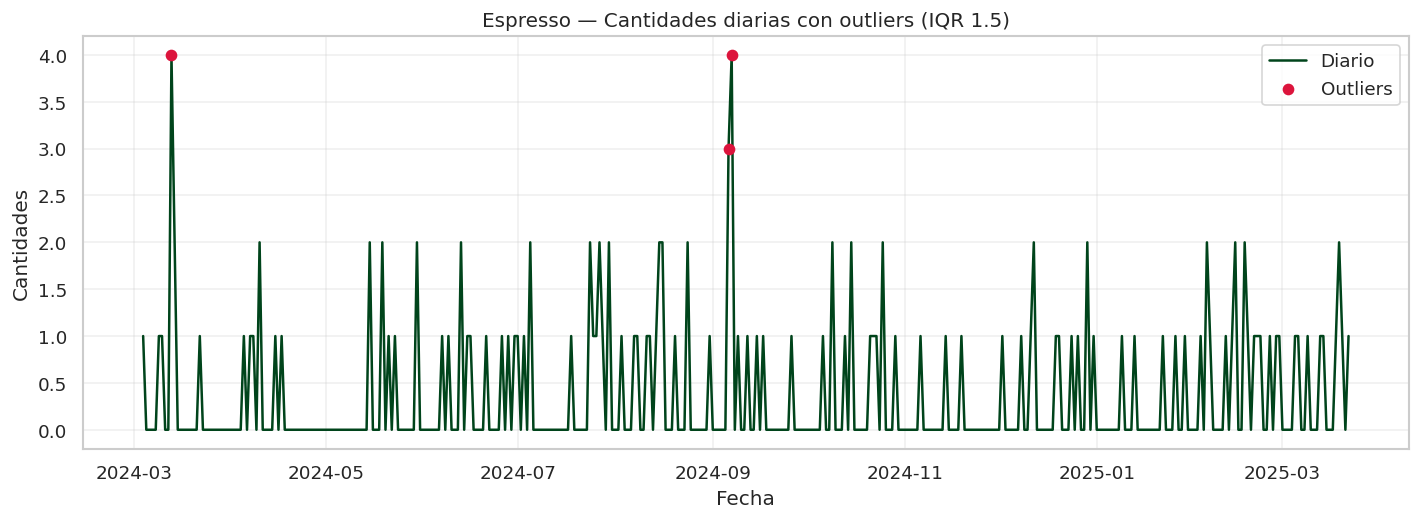

ADF Espresso: -18.0211 | p-value: 0.0000


/tmp/ipython-input-1081176784.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tmp, x="dow", y="quantity",


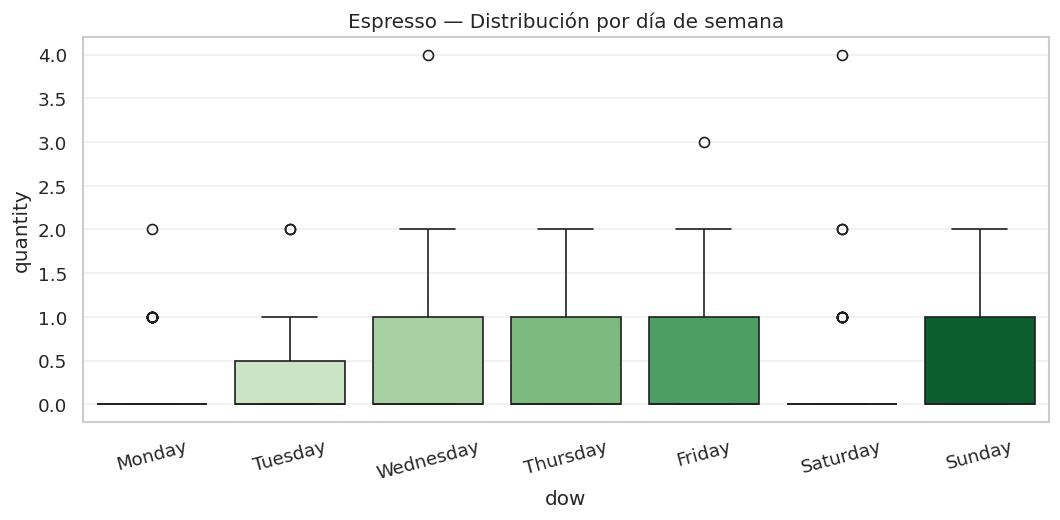

/tmp/ipython-input-1081176784.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tmp, x="month_name", y="quantity", order=orden_meses, palette="Greens")


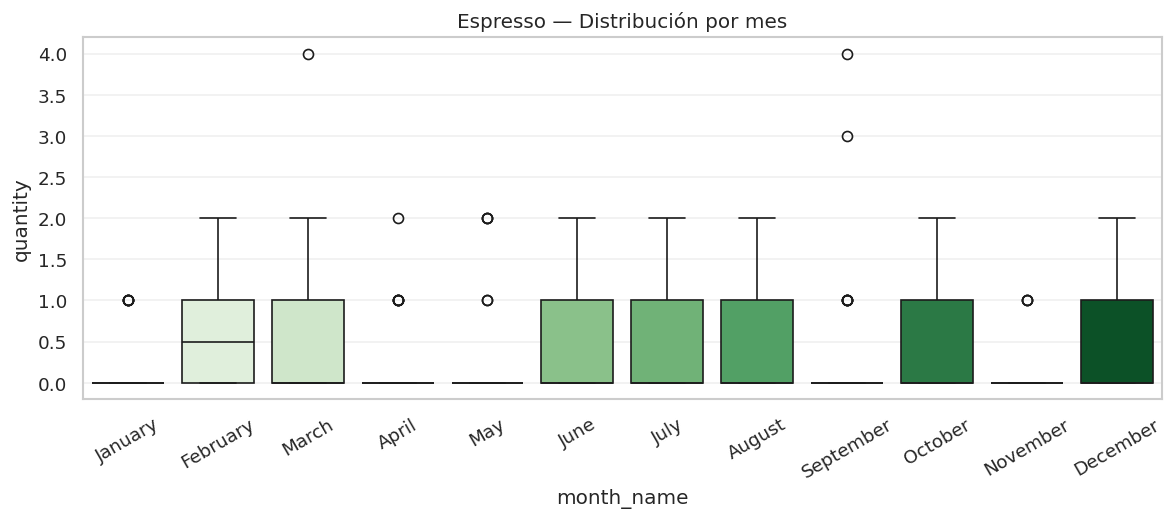

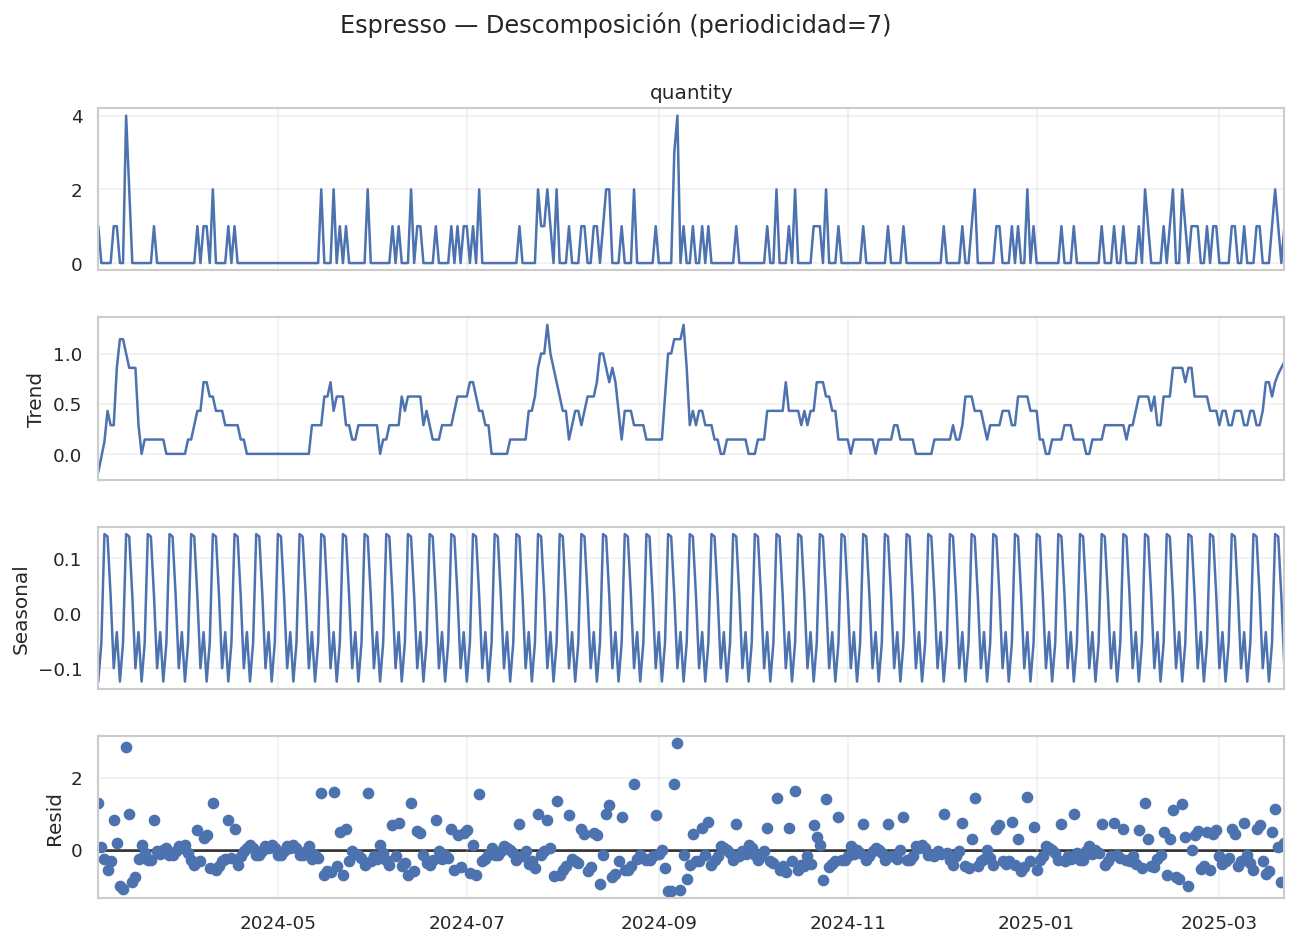

In [ ]:
# === Celda 10 — ANÁLISIS: ESPRESSO ===
serie = df_espresso["quantity"]

# Descriptivos
desc = serie.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).to_frame("quantity")
iqr = desc.loc["75%","quantity"] - desc.loc["25%","quantity"]

print("=== Estadísticos descriptivos (Espresso) ===")
display(desc)
print(f"IQR: {iqr:.3f}")
print(f"Skewness: {skew(serie, bias=False):.3f}")
print(f"Kurtosis: {kurtosis(serie, fisher=True, bias=False):.3f}")

# Outliers por IQR 1.5
q1, q3 = serie.quantile([0.25, 0.75])
low_thr, high_thr = q1 - 1.5*(q3-q1), q3 + 1.5*(q3-q1)
mask = (serie < low_thr) | (serie > high_thr)
print("➤ Outliers (Espresso):", int(mask.sum()))
df_espresso.loc[mask, ["date","quantity"]].to_csv("espresso_outliers_iqr.csv", index=False)

# Serie + outliers
plt.figure(figsize=(12,4.5))
plt.plot(df_espresso["date"], df_espresso["quantity"], color=GREENS[4], label="Diario")
plt.scatter(df_espresso.loc[mask,"date"], df_espresso.loc[mask,"quantity"],
            color="crimson", zorder=5, label="Outliers")
plt.title("Espresso — Cantidades diarias con outliers (IQR 1.5)")
plt.xlabel("Fecha"); plt.ylabel("Cantidades"); plt.legend(); plt.tight_layout(); plt.show()

# ADF
adf = adfuller(df_espresso.set_index('date')['quantity'])
print(f"ADF Espresso: {adf[0]:.4f} | p-value: {adf[1]:.4f}")

# Boxplots (DOW / Mes)
tmp = df_espresso.assign(dow=df_espresso['date'].dt.day_name(),
                         month_name=df_espresso['date'].dt.month_name())

plt.figure(figsize=(9,4.5))
sns.boxplot(data=tmp, x="dow", y="quantity",
            order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
            palette="Greens")
plt.title("Espresso — Distribución por día de semana"); plt.xticks(rotation=15); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4.5))
orden_meses = ["January","February","March","April","May","June","July","August",
               "September","October","November","December"]
sns.boxplot(data=tmp, x="month_name", y="quantity", order=orden_meses, palette="Greens")
plt.title("Espresso — Distribución por mes"); plt.xticks(rotation=30); plt.tight_layout(); plt.show()

# Descomposición semanal
if len(df_espresso) >= 14:
    res = seasonal_decompose(df_espresso.set_index("date")["quantity"],
                             model="additive", period=7, extrapolate_trend="freq")
    fig = res.plot(); fig.set_size_inches(12,8)
    fig.suptitle("Espresso — Descomposición (periodicidad=7)", y=1.02)
    plt.show()
else:
    print("⚠️ Datos insuficientes para descomposición (≥ 14 observaciones).")



In [ ]:
# === Celda 11 — MODELADO con Five-Fold CV: ESPRESSO ===
y_expr = df_espresso.set_index('date')['quantity'].astype(float)

# 1) SARIMAX baseline
r_sar_expr, m_sar_expr = evaluate_sarimax_cv(
    y_expr, order=(1,0,1), seasonal_order=(1,0,1,7)
)
print(f"SARIMAX baseline (Espresso) — RMSE folds: {np.round(r_sar_expr,3)} | media={m_sar_expr:.3f}")

# 2) Auto-SARIMAX (optimiza una vez y reutiliza)
r_asar_expr, m_asar_expr, cfg_expr = evaluate_auto_sarimax_cv(
    y_expr, s=7, optimize_each_fold=False
)
print(f"Auto-SARIMAX (Espresso) — RMSE folds: {np.round(r_asar_expr,3)} | media={m_asar_expr:.3f} | cfg*={cfg_expr}")

# 3) Prophet (define la función si no existe)
if 'evaluate_prophet_cv' not in globals():
    def evaluate_prophet_cv(df_daily):
        dfp = df_daily.rename(columns={'date':'ds','quantity':'y'})[['ds','y','is_weekend','is_holiday']].copy()
        scores = []
        for tr_idx, te_idx in TimeSeriesSplit(n_splits=5).split(range(len(dfp))):
            tr, te = dfp.iloc[tr_idx].copy(), dfp.iloc[te_idx].copy()
            m = Prophet(seasonality_mode='multiplicative',
                        yearly_seasonality=True, weekly_seasonality=True,
                        changepoint_prior_scale=0.05, seasonality_prior_scale=5.0)
            m.add_regressor('is_weekend', mode='multiplicative')
            m.add_regressor('is_holiday', mode='multiplicative')
            m.fit(tr)
            yhat = m.predict(te[['ds','is_weekend','is_holiday']].copy())
            scores.append(np.sqrt(mean_squared_error(te['y'].values, yhat['yhat'].values)))
        return scores, float(np.mean(scores))

r_prop_expr, m_prop_expr = evaluate_prophet_cv(df_espresso)
print(f"Prophet (Espresso) — RMSE folds: {np.round(r_prop_expr,3)} | media={m_prop_expr:.3f}")

# 4) LightGBM (lags + estacionalidad)
r_lgb_expr, m_lgb_expr = evaluate_lgb_cv(df_espresso, lags=(1,7,14,30))
print(f"LightGBM (Espresso) — RMSE folds: {np.round(r_lgb_expr,3)} | media={m_lgb_expr:.3f}")

metrics_espresso_cv = {
    "SARIMAX": m_sar_expr,
    "AutoSARIMAX": m_asar_expr,
    "Prophet": m_prop_expr,
    "LightGBM": m_lgb_expr
}
metrics_espresso_cv


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

SARIMAX baseline (Espresso) — RMSE folds: [0.708 0.939 0.668 0.501 0.655] | media=0.694


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Auto-SARIMAX (Espresso) — RMSE folds: [0.627 0.897 0.734 0.517 0.613] | media=0.678 | cfg*=((1, 0, 3), (1, 1, 2, 7))


00:15:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlvhqfkq/0tf0fwhs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlvhqfkq/la_j1liv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3895', 'data', 'file=/tmp/tmpqlvhqfkq/0tf0fwhs.json', 'init=/tmp/tmpqlvhqfkq/la_j1liv.json', 'output', 'file=/tmp/tmpqlvhqfkq/prophet_modelfn2ix08l/prophet_model-20250812001551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:15:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:15:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run 

Prophet (Espresso) — RMSE folds: [8.962 0.893 0.628 0.518 0.672] | media=2.335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 3
[LightGBM] [Info] Start training from score 0.254237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

{'SARIMAX': 0.6943322191960137,
 'AutoSARIMAX': 0.6775218040291417,
 'Prophet': 2.334737033027154,
 'LightGBM': 0.6341975894459201}

,AutoSARIMAX,LightGBM,Prophet,SARIMAX
Latte,2.039,1.791,2.294,2.170
Espresso,0.678,0.634,2.335,0.694


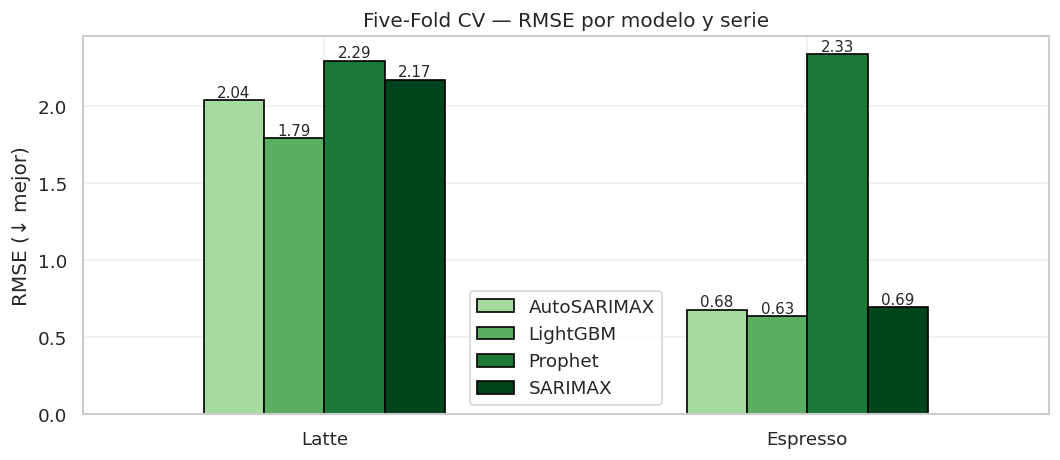

In [ ]:
# === Celda 12 — COMPARACIÓN: Promedio RMSE five-fold CV ===
df_cmp_cv = (pd.DataFrame([metrics_latte_cv, metrics_espresso_cv],
                          index=['Latte','Espresso'])
               .round(3)
               .sort_index(axis=1))
display(df_cmp_cv)

ax = df_cmp_cv.plot(kind='bar', figsize=(9,4),
                    color=[GREENS[1], GREENS[2], GREENS[3], GREENS[4]],
                    edgecolor='black')
plt.title("Five-Fold CV — RMSE por modelo y serie")
plt.ylabel("RMSE (↓ mejor)"); plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.show()


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean
SARIMAX,1.771,2.322,2.140,2.904,1.715,2.170
AutoSARIMAX,1.896,2.441,2.110,2.073,1.678,2.039
Prophet,2.810,2.311,2.310,2.114,1.925,2.294
LightGBM,1.388,2.323,2.014,1.527,1.704,1.791


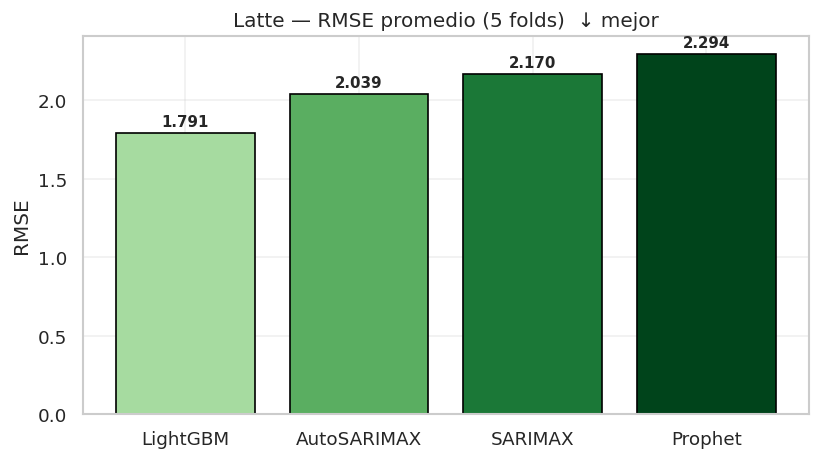

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean
SARIMAX,0.708,0.939,0.668,0.501,0.655,0.694
AutoSARIMAX,0.627,0.897,0.734,0.517,0.613,0.678
Prophet,8.962,0.893,0.628,0.518,0.672,2.335
LightGBM,0.619,0.845,0.552,0.512,0.644,0.634


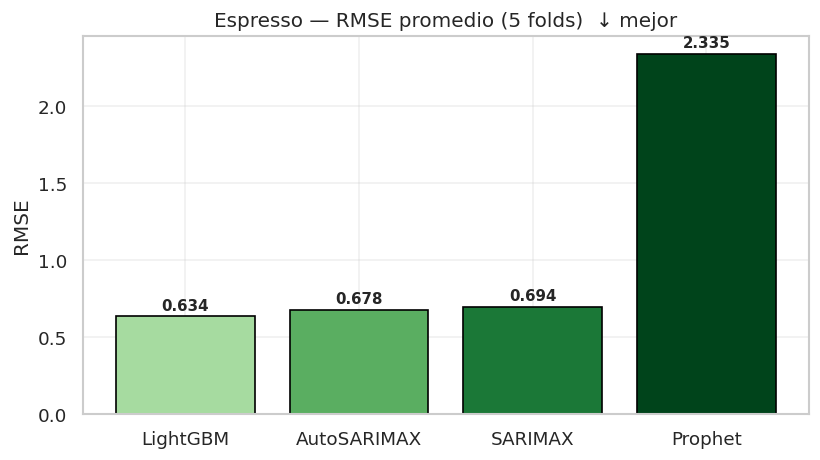

In [ ]:
# === Celda 12A — Tablas por fold + barras de promedios ===
def rmse_table(series_name, folds_dict, means_dict):
    df_folds = pd.DataFrame(folds_dict).T
    df_folds.columns = [f'Fold {i+1}' for i in range(df_folds.shape[1])]
    df_folds['Mean'] = pd.Series(means_dict)
    df_folds = df_folds.round(3)

    display(df_folds.style
            .format(precision=3)
            .highlight_min(axis=0, color="#d9f0d3")
            .highlight_min(axis=1, color="#a6dba0")
            .set_caption(f"RMSE por fold — {series_name}"))

    means_sorted = pd.Series(means_dict).sort_values()
    fig, ax = plt.subplots(figsize=(7,4))
    bars = ax.bar(means_sorted.index, means_sorted.values,
                  color=['#a6dba0','#5aae61','#1b7837','#00441b'], edgecolor='black')
    ax.set_title(f"{series_name} — RMSE promedio (5 folds)  ↓ mejor")
    ax.set_ylabel("RMSE")
    for b in bars:
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.01*means_sorted.max(),
                f"{b.get_height():.3f}", ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.xticks(rotation=0); plt.tight_layout(); plt.show()

# Latte
rmse_table("Latte",
    folds_dict={
        "SARIMAX":     r_sar_latte,
        "AutoSARIMAX": r_asar_latte,
        "Prophet":     r_prop_latte,
        "LightGBM":    r_lgb_latte
    },
    means_dict=metrics_latte_cv
)

# Espresso
rmse_table("Espresso",
    folds_dict={
        "SARIMAX":     r_sar_expr,
        "AutoSARIMAX": r_asar_expr,
        "Prophet":     r_prop_expr,
        "LightGBM":    r_lgb_expr
    },
    means_dict=metrics_espresso_cv
)



In [ ]:
# === Celda 12B — SARIMAX summary (fit en serie completa, para interpretación) ===
def sarimax_summary(y, order, seasonal_order, title):
    res = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    print(f"\n{'='*70}\n{title}\n{'='*70}")
    print(res.summary())
    return res

# Latte
y_latte_full = df_latte.set_index('date')['quantity'].astype(float)
res_latte_base = sarimax_summary(y_latte_full, (1,0,1), (1,0,1,7),
                                 "Latte — SARIMAX baseline (1,0,1)x(1,0,1,7)")
if 'cfg_latte' in globals() and cfg_latte is not None:
    (order_l, seas_l) = cfg_latte
else:
    (order_l, seas_l), _, _ = auto_sarimax_endog(y_latte_full, s=7, criterion="aic")
res_latte_auto = sarimax_summary(y_latte_full, order_l, seas_l,
                                 f"Latte — Auto-SARIMAX {order_l}x{seas_l}")

# Espresso
y_expr_full = df_espresso.set_index('date')['quantity'].astype(float)
res_expr_base = sarimax_summary(y_expr_full, (1,0,1), (1,0,1,7),
                                "Espresso — SARIMAX baseline (1,0,1)x(1,0,1,7)")
if 'cfg_expr' in globals() and cfg_expr is not None:
    (order_e, seas_e) = cfg_expr
else:
    (order_e, seas_e), _, _ = auto_sarimax_endog(y_expr_full, s=7, criterion="aic")
res_expr_auto = sarimax_summary(y_expr_full, order_e, seas_e,
                                f"Espresso — Auto-SARIMAX {order_e}x{seas_e}")



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Latte — SARIMAX baseline (1,0,1)x(1,0,1,7)
                                     SARIMAX Results                                     
Dep. Variable:                          quantity   No. Observations:                  388
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -729.155
Date:                           Tue, 12 Aug 2025   AIC                           1468.309
Time:                                   00:23:18   BIC                           1487.997
Sample:                               03-01-2024   HQIC                          1476.122
                                    - 03-23-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9991      0.004    238.806      0.000       0.991       1.007

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  


Latte — Auto-SARIMAX (2, 1, 3)x(0, 1, 2, 7)
                                       SARIMAX Results                                        
Dep. Variable:                               quantity   No. Observations:                  388
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 7)   Log Likelihood                -703.535
Date:                                Tue, 12 Aug 2025   AIC                           1423.070
Time:                                        00:23:23   BIC                           1454.203
Sample:                                    03-01-2024   HQIC                          1435.446
                                         - 03-23-2025                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1493      0.012    -

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Espresso — Auto-SARIMAX (1, 0, 3)x(1, 1, 2, 7)
                                       SARIMAX Results                                        
Dep. Variable:                               quantity   No. Observations:                  384
Model:             SARIMAX(1, 0, 3)x(1, 1, [1, 2], 7)   Log Likelihood                -346.836
Date:                                Tue, 12 Aug 2025   AIC                            709.672
Time:                                        00:23:26   BIC                            740.738
Sample:                                    03-04-2024   HQIC                           722.026
                                         - 03-22-2025                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6718      0.422  

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 5. Modelado con Prophet

In [ ]:
# === Celda 12D — Helpers de CV con predicciones por fold + plot ===
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from sklearn.model_selection import TimeSeriesSplit

FOLD_LINE_STYLES = ['--', '--', '--', '--', '--']
FOLD_COLORS      = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 5 colores
FOLD_BANDS       = ['#1f77b420', '#ff7f0e20', '#2ca02c20', '#d6272820', '#9467bd20']  # con alpha

def _tscv_indices(n, n_splits=5):
    return list(TimeSeriesSplit(n_splits=n_splits).split(range(n)))

def plot_cv_segments(y_full, segments, title, ylabel="Cantidad"):
    """
    y_full: pd.Series con índice datetime (serie completa)
    segments: lista de dicts por fold:
        {'start': fecha_inicio_test, 'end': fecha_fin_test,
         'y_true': np.array, 'y_pred': np.array}
    """
    fig, ax = plt.subplots(figsize=(12,4.5))
    # Observado completo
    ax.plot(y_full.index, y_full.values, color='#bdbdbd', lw=2, label='Observado (serie completa)')

    for i, seg in enumerate(segments):
        col = FOLD_COLORS[i % len(FOLD_COLORS)]
        style = FOLD_LINE_STYLES[i % len(FOLD_LINE_STYLES)]
        band = FOLD_BANDS[i % len(FOLD_BANDS)]

        t_idx = y_full.index[(y_full.index >= seg['start']) & (y_full.index <= seg['end'])]
        # banda del fold
        if len(t_idx) > 0:
            ax.axvspan(t_idx.min(), t_idx.max(), color=band, zorder=0)

        # línea predicha
        ax.plot(t_idx, seg['y_pred'], linestyle=style, color=col, lw=2, label=f'Fold {i+1}')

    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel("Fecha"); ax.set_ylabel(ylabel)
    ax.legend(loc='upper left', ncols=2, frameon=False)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---- SARIMAX baseline: devuelve segmentos con predicciones por fold ----
def sarimax_cv_segments(y, order=(1,0,1), seasonal_order=(1,0,1,7)):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    y = y.astype(float)
    segs = []
    for tr_idx, te_idx in _tscv_indices(len(y), 5):
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        res = SARIMAX(y_tr, order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        fc = res.forecast(steps=len(y_te))
        segs.append({
            'start': y.index[te_idx[0]],
            'end':   y.index[te_idx[-1]],
            'y_true': y_te.values,
            'y_pred': fc.values
        })
    return segs

# ---- Auto-SARIMAX: usa la mejor config del primer fold para todos (rápido y consistente) ----
def auto_sarimax_cv_segments(y, s=7):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    y = y.astype(float)
    segs = []
    best_cfg = None
    for k, (tr_idx, te_idx) in enumerate(_tscv_indices(len(y), 5)):
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        if best_cfg is None:
            best_cfg, _, _ = auto_sarimax_endog(y_tr, s=s, criterion="aic")
        (order, seasonal) = best_cfg
        res = SARIMAX(y_tr, order=order, seasonal_order=seasonal,
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        fc = res.forecast(steps=len(y_te))
        segs.append({
            'start': y.index[te_idx[0]],
            'end':   y.index[te_idx[-1]],
            'y_true': y_te.values,
            'y_pred': fc.values
        })
    return segs, best_cfg

# ---- Prophet: entrena por fold y predice sobre el bloque de test ----
def prophet_cv_segments(df_daily):
    from prophet import Prophet
    dfp = df_daily.rename(columns={'date':'ds','quantity':'y'})[['ds','y','is_weekend','is_holiday']].copy()
    segs = []
    for tr_idx, te_idx in _tscv_indices(len(dfp), 5):
        tr, te = dfp.iloc[tr_idx].copy(), dfp.iloc[te_idx].copy()
        m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True,
                    changepoint_prior_scale=0.05, seasonality_prior_scale=5.0)
        m.add_regressor('is_weekend', mode='multiplicative')
        m.add_regressor('is_holiday', mode='multiplicative')
        m.fit(tr)
        future = te[['ds','is_weekend','is_holiday']].copy()
        yhat = m.predict(future)
        segs.append({
            'start': te['ds'].iloc[0],
            'end':   te['ds'].iloc[-1],
            'y_true': te['y'].values,
            'y_pred': yhat['yhat'].values
        })
    return segs

# ---- LightGBM: lags + seno/cos; respetar índices tras dropear NaN de lags ----
def lgb_cv_segments(df_daily, lags=(1,7,14,30), lgb_kwargs=None):
    import lightgbm as lgb
    if lgb_kwargs is None:
        lgb_kwargs = dict(objective='regression', n_estimators=500, learning_rate=0.02,
                          max_depth=-1, subsample=0.9, colsample_bytree=0.9,
                          reg_lambda=1.0, verbosity=-1)
    fe = df_daily.copy()
    for L in lags:
        fe[f'lag_{L}'] = fe['quantity'].shift(L)
    fe['sin_month'] = np.sin(2*np.pi*fe['month']/12)
    fe['cos_month'] = np.cos(2*np.pi*fe['month']/12)
    fe = fe.dropna().set_index('date')  # ojo: se acorta la serie

    X = fe.drop(columns=['quantity'])
    y = fe['quantity'].astype(float)
    idx = X.index  # fechas válidas luego de lags

    segs = []
    for tr_idx, te_idx in _tscv_indices(len(y), 5):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        model = lgb.LGBMRegressor(**lgb_kwargs)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_te, y_te)],
                  eval_metric='rmse',
                  callbacks=[lgb.early_stopping(50, verbose=False)])
        pred = model.predict(X_te)
        segs.append({
            'start': idx[te_idx[0]],
            'end':   idx[te_idx[-1]],
            'y_true': y_te.values,
            'y_pred': pred
        })
    return segs


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

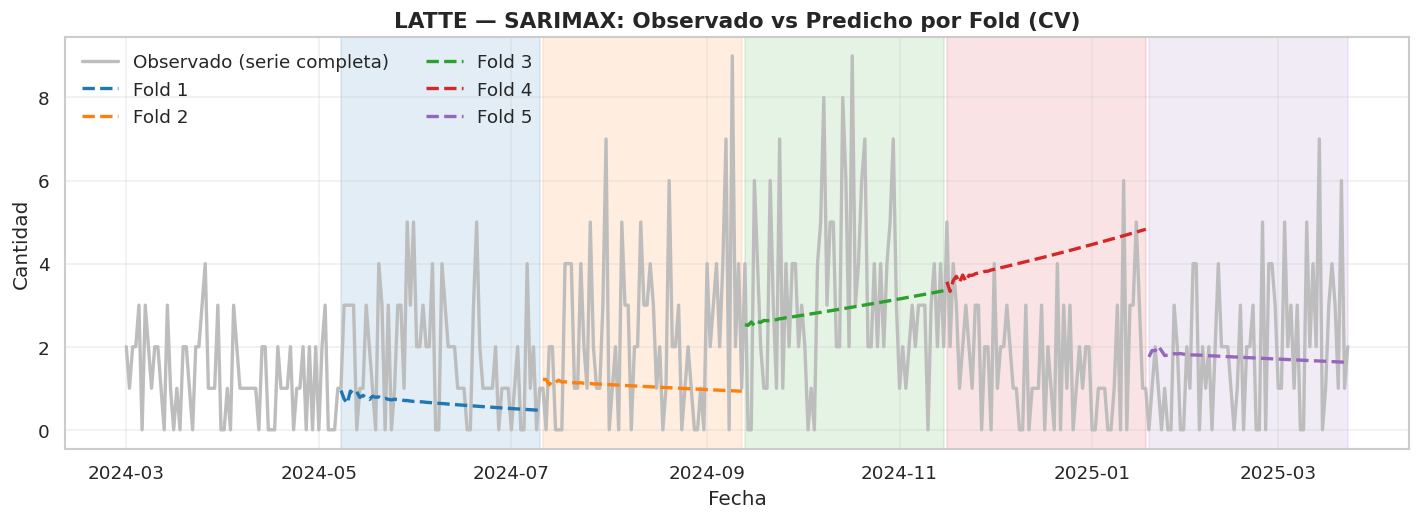

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

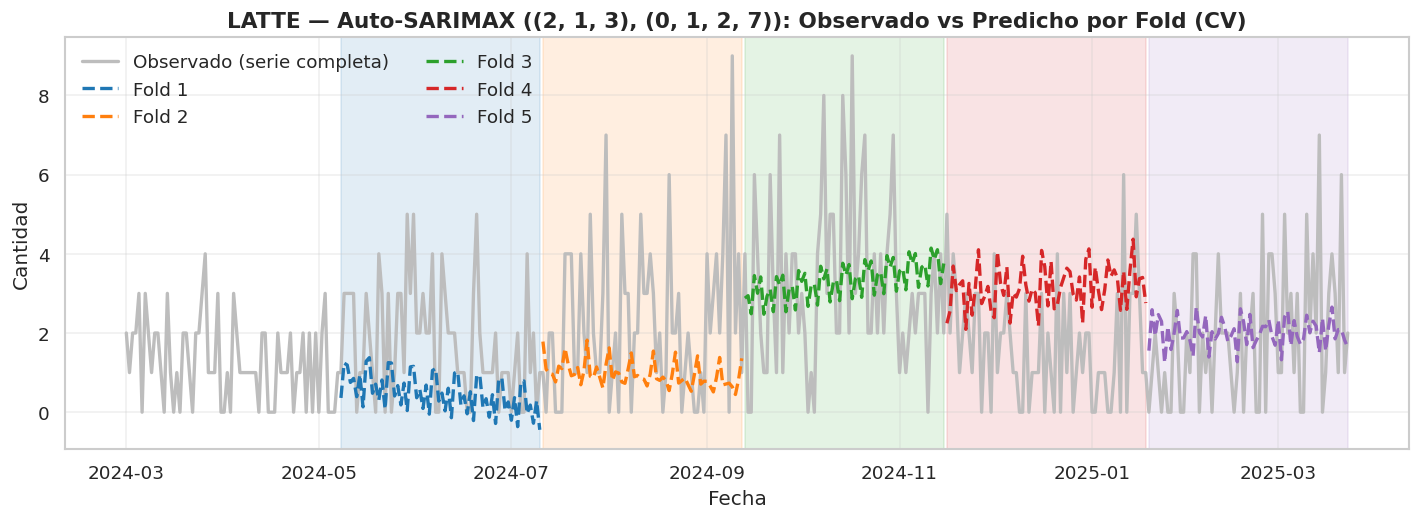

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlvhqfkq/i96vkx6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlvhqfkq/cfpfyk3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56953', 'data', 'file=/tmp/tmpqlvhqfkq/i96vkx6n.json', 'init=/tmp/tmpqlvhqfkq/cfpfyk3f.json', 'output', 'file=/tmp/tmpqlvhqfkq/prophet_modelc_ainohg/prophet_model-20250812002916.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:29:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq

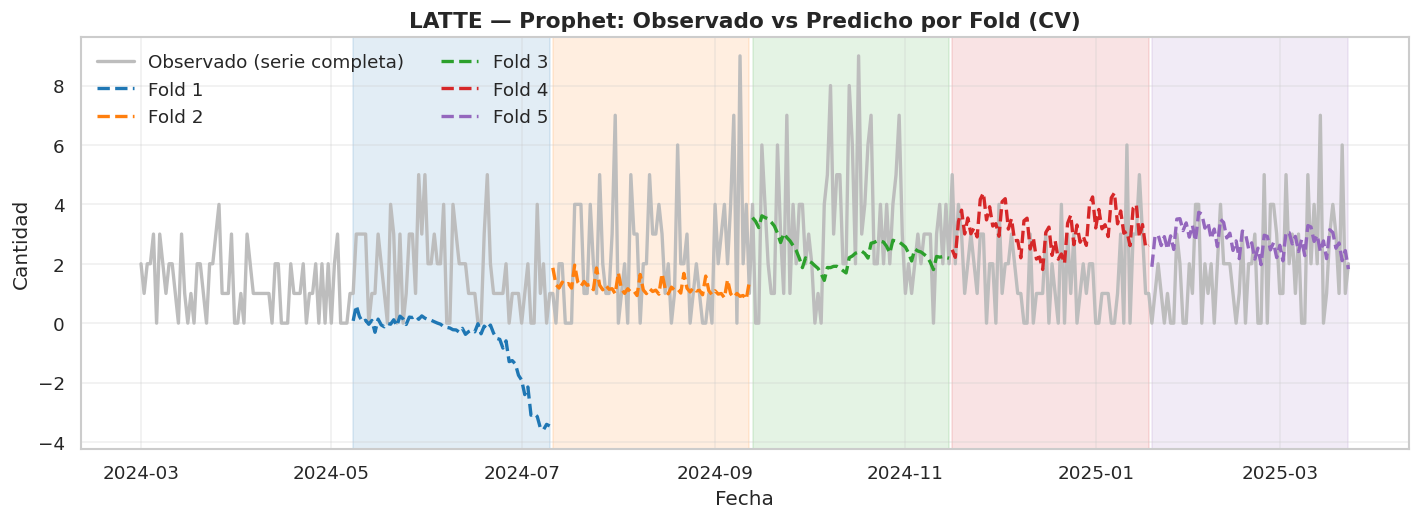

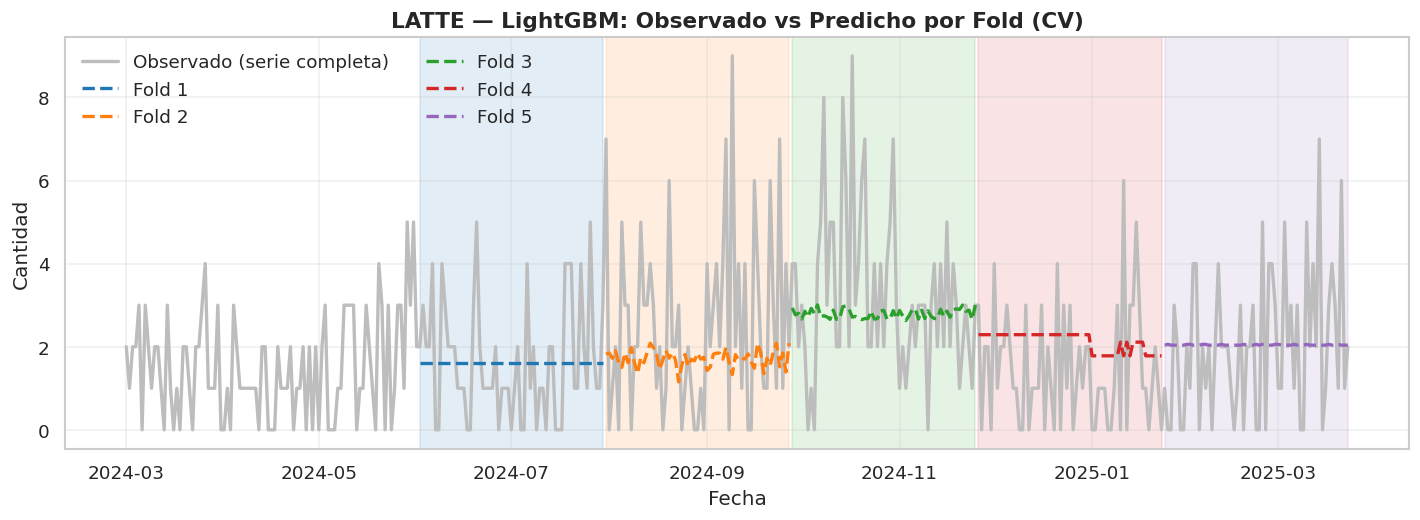

In [ ]:
# === Celda 12E — LATTE: Observado vs Predicho por Fold (uno por modelo) ===
y_lat = df_latte.set_index('date')['quantity'].astype(float)

# SARIMAX baseline
segs_lat_sar = sarimax_cv_segments(y_lat, order=(1,0,1), seasonal_order=(1,0,1,7))
plot_cv_segments(y_lat, segs_lat_sar, "LATTE — SARIMAX: Observado vs Predicho por Fold (CV)")

# Auto-SARIMAX
segs_lat_asar, cfg_lat = auto_sarimax_cv_segments(y_lat, s=7)
plot_cv_segments(y_lat, segs_lat_asar, f"LATTE — Auto-SARIMAX {cfg_lat}: Observado vs Predicho por Fold (CV)")

# Prophet
segs_lat_prop = prophet_cv_segments(df_latte)
plot_cv_segments(y_lat, segs_lat_prop, "LATTE — Prophet: Observado vs Predicho por Fold (CV)")

# LightGBM
segs_lat_lgb = lgb_cv_segments(df_latte, lags=(1,7,14,30))
plot_cv_segments(y_lat, segs_lat_lgb, "LATTE — LightGBM: Observado vs Predicho por Fold (CV)")
